In [13]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import time
from utils import load_data, split_data
from train import train, trial
from metrics import compute_accuracy
from torchsummary import summary

In [7]:
# Load train and test data
train_data, test_data = load_data()

# Split data in train-validation-test
train_loader, valid_loader, test_loader = split_data(train_data, test_data)

In [142]:
class CNN(nn.Module):
    def __init__(self, mode='baseline', verbose=True):
        super(CNN, self).__init__()
        
        ## Siamese block
        self.conv1 = nn.Conv2d(1, 24, kernel_size=3)
        self.conv2 = nn.Conv2d(24, 49, kernel_size=3)
        self.fc1 = nn.Linear(14*14, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Decision block
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, 1)
        
        # Regularizers
        if mode == 'baseline':
            self.drop = nn.Dropout(0)
        elif mode == 'dropout':
            self.drop = nn.Dropout(0.2)
        else:
            raise ValueError('Unknown mode. Try "baseline" or "dropout".')
        self.pool = nn.MaxPool2d(2,2)
        
        # Activation fcns
        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.sigmoid = nn.Sigmoid()
        
        if verbose:
            print(f'Parameters: {self.count_params()}')

    def count_params(self):
        return sum(p.numel() for p in self.parameters())
    
    def siamese_block(self, x):
        x = self.pool(self.relu(self.conv1(x.unsqueeze(1))))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.fc1(x.flatten(start_dim=1)))
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        
        return x
    
    def forward(self, x):
        x1, x2 = x.unbind(1)
        
        x1, x2 = self.siamese_block(x1), self.siamese_block(x2)
        
        # Dim x1: Nx1x10
        aux = torch.stack([x1, x2], dim=1)
        
        # Dim aux: Nx2x10
        x = torch.cat([x1, x2], dim=1)
        
        # Dim x: Nx20
        x = self.relu(self.fc3(x.flatten(start_dim=1)))
        x = self.drop(x)
        x = self.sigmoid(self.fc4(x))
        return x.squeeze(), aux

In [146]:
net = CNN(mode='dropout')

Parameters: 37600


In [147]:
start = time.time()
tr_losses = train(net, train_loader, valid_loader, alpha=1, alpha_decay=.9)
print(time.time()-start)

Epoch 1/25, Binary loss: 0.688, Auxiliary loss: 4.220, Validation loss: 2.761, 
Epoch 2/25, Binary loss: 0.680, Auxiliary loss: 3.375, Validation loss: 2.748, 
Epoch 3/25, Binary loss: 0.667, Auxiliary loss: 3.074, Validation loss: 2.727, 
Epoch 4/25, Binary loss: 0.669, Auxiliary loss: 2.878, Validation loss: 2.727, 
Epoch 5/25, Binary loss: 0.684, Auxiliary loss: 2.846, Validation loss: 2.685, 
Epoch 6/25, Binary loss: 0.653, Auxiliary loss: 2.712, Validation loss: 2.636, 
Epoch 7/25, Binary loss: 0.635, Auxiliary loss: 2.160, Validation loss: 2.593, 
Epoch 8/25, Binary loss: 0.611, Auxiliary loss: 2.019, Validation loss: 2.463, 
Epoch 9/25, Binary loss: 0.643, Auxiliary loss: 1.969, Validation loss: 2.386, 
Epoch 10/25, Binary loss: 0.583, Auxiliary loss: 2.427, Validation loss: 2.246, 
Epoch 11/25, Binary loss: 0.562, Auxiliary loss: 1.962, Validation loss: 2.128, 
Epoch 12/25, Binary loss: 0.587, Auxiliary loss: 1.815, Validation loss: 2.004, 
Epoch 13/25, Binary loss: 0.556, Auxi

In [148]:
compute_accuracy(net, test_loader)

0.89

In [ ]:
_, tr_accuracies, te_accuracies = trial(CNN(mode='baseline'), train_data, test_data, alpha=0, alpha_decay=1)

Parameters: 37600
Trial 1/30... Training time: 13.36 s
Loss: 0.0420, Train acc: 1.0000, Test acc: 0.8440
Trial 2/30... Training time: 13.07 s
Loss: 0.0845, Train acc: 1.0000, Test acc: 0.8330
Trial 3/30... Training time: 13.09 s
Loss: 0.0278, Train acc: 1.0000, Test acc: 0.8280
Trial 4/30... Training time: 12.90 s
Loss: 0.0373, Train acc: 1.0000, Test acc: 0.8380
Trial 5/30... Training time: 13.09 s
Loss: 0.3821, Train acc: 1.0000, Test acc: 0.8290
Trial 6/30... Training time: 12.93 s
Loss: 0.0305, Train acc: 1.0000, Test acc: 0.8460
Trial 7/30... Training time: 12.92 s
Loss: 0.0568, Train acc: 1.0000, Test acc: 0.8300
Trial 8/30... Training time: 13.02 s
Loss: 0.0489, Train acc: 1.0000, Test acc: 0.8300
Trial 9/30... Training time: 12.93 s
Loss: 0.0346, Train acc: 1.0000, Test acc: 0.8350
Trial 10/30... Training time: 13.82 s
Loss: 0.0588, Train acc: 1.0000, Test acc: 0.8450
Trial 11/30... Training time: 14.87 s
Loss: 0.0361, Train acc: 1.0000, Test acc: 0.8360
Trial 12/30... Training

In [ ]:
print('Train accuracy - mean: %.4f, std: %.4f, median: %.4f' % 
     (tr_accuracies.mean(), tr_accuracies.std(), tr_accuracies.median()))
print('Test accuracy - mean: %.4f, std: %.4f, median: %.4f' % 
     (te_accuracies.mean(), te_accuracies.std(), te_accuracies.median()))

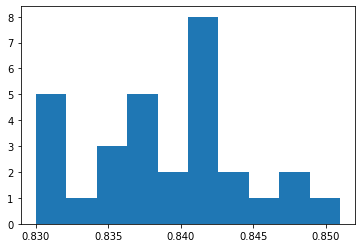

In [117]:
plt.hist(te_accuracies)
plt.show()